# Project Group 32 
## Cancer Classification - Logistic Regression Model 
### Mukta Jaiswal, Nathan D'Cruz

### Some considerations 
- Split proportion?
- check for overfitting? 

In [152]:
import operator
from numpy import mean, std
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, f1_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [157]:
# Easy settings
DATA_FILE_NAME = "./Cancer_Data.csv"
TEST_SIZE = 0.2
KFOLD_SPLITS = 10

In [137]:
# Read data
dataset = pd.read_csv(DATA_FILE_NAME)
print(dataset.iloc[:,1:6])

    diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean
0           M        17.99         10.38          122.80     1001.0
1           M        20.57         17.77          132.90     1326.0
2           M        19.69         21.25          130.00     1203.0
3           M        11.42         20.38           77.58      386.1
4           M        20.29         14.34          135.10     1297.0
..        ...          ...           ...             ...        ...
564         M        21.56         22.39          142.00     1479.0
565         M        20.13         28.25          131.20     1261.0
566         M        16.60         28.08          108.30      858.1
567         M        20.60         29.33          140.10     1265.0
568         B         7.76         24.54           47.92      181.0

[569 rows x 5 columns]


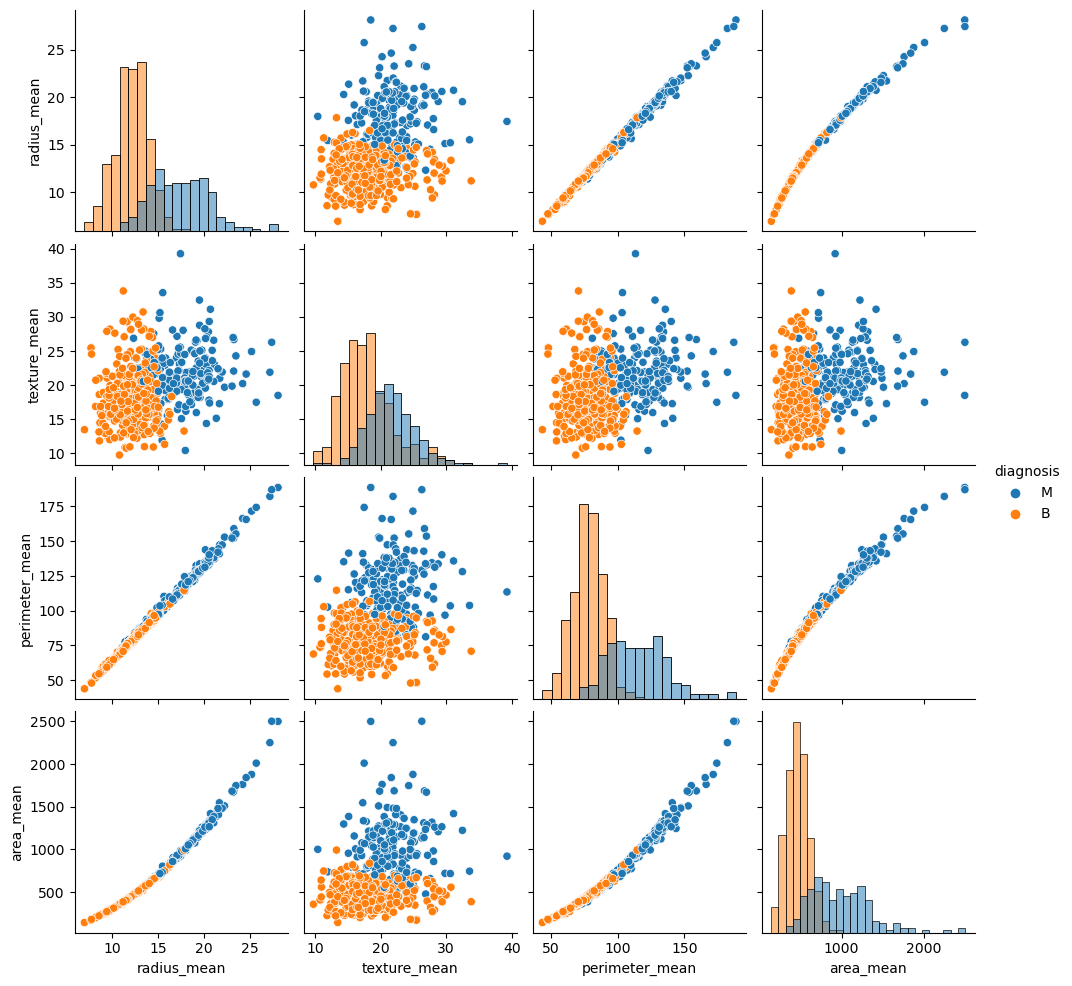

In [60]:
# Data visualization
sns.pairplot(dataset.iloc[:,1:6], hue = 'diagnosis', diag_kind='hist');
plt.show()

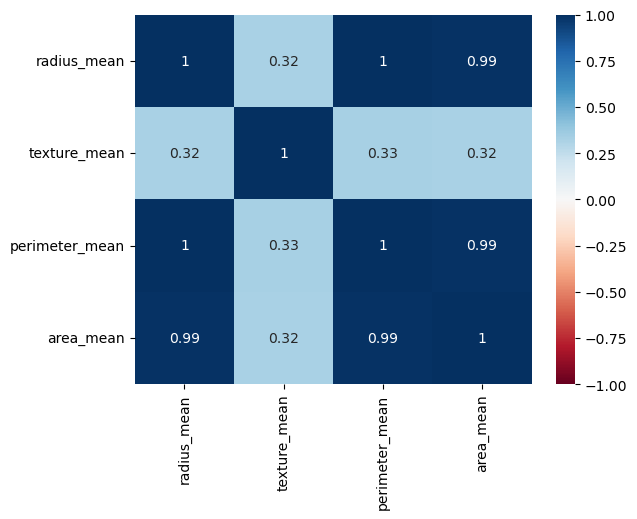

In [61]:
# Data visualization
correlation = dataset.iloc[:,2:6].copy().corr()
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, cmap="RdBu")
plt.show()

Confusion Matrix:
 [[11  0]
 [ 5 41]]
TPR: 0.8913043478260869
TNR: 1.0
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       1.00      0.89      0.94        46

    accuracy                           0.91        57
   macro avg       0.84      0.95      0.88        57
weighted avg       0.94      0.91      0.92        57

AUC1 SCORE: 0.9940711462450592
Confusion Matrix:
 [[35  0]
 [ 1 21]]
TPR: 0.9545454545454546
TNR: 1.0
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.95      0.98        22

    accuracy                           0.98        57
   macro avg       0.99      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57

AUC1 SCORE: 0.996103896103896
Confusion Matrix:
 [[36  0]
 [ 1 20]]
TPR: 0.9523809523809523
TNR: 1.0
              precision    recall  f1-score   support

           0     

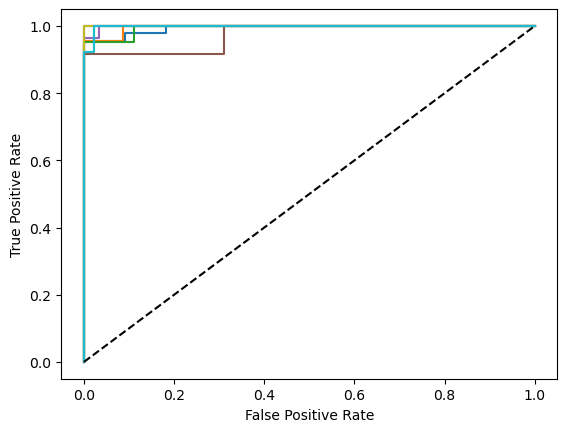

In [158]:
# Pre-process data 
X = dataset.drop('diagnosis', axis=1).drop('id', axis=1)
y = dataset['diagnosis']

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_rescaled, columns=X.columns)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

# Binarize
y = y.map({'B': 0, 'M': 1})
#y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})

# Train a bunch of models
kf = KFold(n_splits=KFOLD_SPLITS)
models = []
i = 0 #keep track of batch number
for train_indices, test_indices in kf.split(X):
    start_train, stop_train = train_indices[0], train_indices[-1]+1
    start_test, stop_test = test_indices[0], test_indices[-1]+1
    
    X_train, X_test = X[start_train:stop_train], X[start_test:stop_test]
    y_train, y_test = y[start_train:stop_train], y[start_test:stop_test]
    # Do Log Reg
    cls = LogisticRegression()
    cls.fit(X_train, y[start_train:stop_train])
    y_pred = cls.predict(X_test)
    y_prob = cls.predict_proba(X_test)
    
    details = {}
    # y_test, y_pred, y_prob
    details["y_test"] = y_test
    details["y_pred"] = y_pred 
    details["y_prob"] = y_prob 
    models.append(details) 
    i += 1
    
# Analyze models
for model in models:
    y_test = model["y_test"]
    y_pred = model["y_pred"]
    y_prob = model["y_prob"]
    
    cmat = confusion_matrix(y_test, y_pred)

    print(f"Confusion Matrix:\n {cmat}")

    # Confusion matrix whose i-th row and j-th column entry indicates the number of 
    # samples with true label being i-th class and predicted label being j-th class.

    tp = cmat[1, 1]
    tn = cmat[0, 0]
    fp = cmat[0, 1]
    fn = cmat[1, 0]

    tpr = tp / (tp + fn) # RECALL/SENSITIVITY 
    print(f"TPR: {tpr}")

    tnr = tn / (tn + fp) # SPECIFICITY
    #tnr = cmat[1][1] / (cmat[1][1] + cmat[0][1])
    print(f"TNR: {tnr}") 

    print(classification_report(y_test, y_pred))

    #fpr0, tpr0, thresholds0 = roc_curve(y_test, y_prob[:, 0])
    #auc0 = roc_auc_score(y_test, y_prob[:, 0])

    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_prob[:, 1])
    auc1 = roc_auc_score(y_test, y_prob[:, 1])

    #plt.plot(fpr0, tpr0)
    # separate these properly later
    plt.plot(fpr1, tpr1)

    #print(f"AUC1 SCORE: {auc0}")
    print(f"AUC1 SCORE: {auc1}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.show()